In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
# tf.config.run_functions_eagerly(True)
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.9.2


In [4]:
(train_ds, test_ds), info = tfds.load('food101', split=['train', 'validation'], shuffle_files=True, as_supervised=True, with_info=True)

In [4]:
print(info)

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_path='~/tensorflow_datasets/food101/2.0.0',
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo

In [5]:
print("Training Set Size: %d" % train_ds.cardinality().numpy())
print("Test Set Size: %d" % test_ds.cardinality().numpy())

Training Set Size: 75750
Test Set Size: 25250


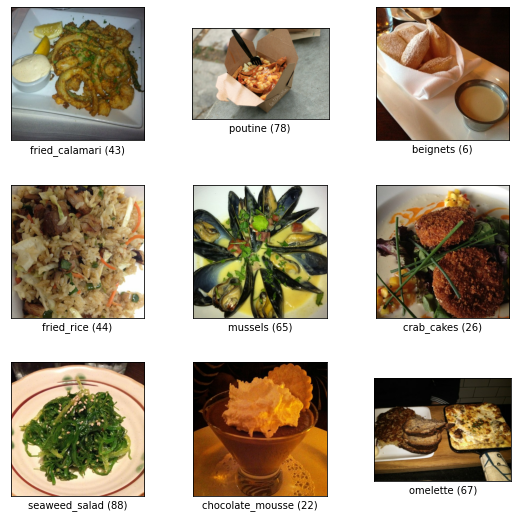

In [6]:
fig = tfds.show_examples(train_ds, info)

# Binary classification with MobileNetV3Small

## Data preparation for binary classification

In [7]:
# get the label for pizza
get_class_name = info.features['label'].str2int
get_class_name("pizza")

76

In [8]:
# code from Zhendong
def tobinary(x, y, food_num):
    food2 = tf.constant(food_num, dtype='int64')
    if tf.equal(y, food2):
        return x, tf.constant([1,0], dtype='int64')
    return x, tf.constant([0,1], dtype='int64')

In [9]:
def sample_data(ds, class_name):
  # get balanced dataset
  ds1 = ds.filter(lambda x, y: y == class_name)
  ds2 = ds.filter(lambda x, y: y != class_name)
  balanced_ds = tf.data.Dataset.sample_from_datasets([ds1, ds2], 
                                                    weights=[0.5, 0.5], 
                                                    seed = 1,
                                                    stop_on_empty_dataset=True)
  # convert to binary labels
  binary_ds = balanced_ds.map(lambda x, y:tobinary(x, y, class_name))

  # resize image
  resized_ds = binary_ds.map(lambda x, y: (tf.image.resize(x, [224, 224]), y))

  return resized_ds

In [10]:
train_ds2 = sample_data(train_ds, 76)
test_ds2 = sample_data(test_ds, 76)

In [ ]:
# number of elements in test set
i = 0
for element in test_ds2:
  i += 1
i

489

In [11]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
train_ds2 = train_ds2.batch(BATCH_SIZE). cache(). shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds2 = test_ds2.batch(BATCH_SIZE). cache(). shuffle(1000).prefetch(buffer_size=AUTOTUNE)

## Binary classification with weights from ImageNet pre-training

In [ ]:
# Create model
mobilenet_model = tf.keras.applications.MobileNetV3Small(
    include_top=False, weights= "imagenet",
     pooling="avg", dropout_rate=0.2, include_preprocessing=True)
predictions = tf.keras.layers.Dense(2, activation='softmax')(mobilenet_model.output)
model = Model(inputs=mobilenet_model.input, outputs=predictions)

In [ ]:
EPOCHS = 25
LEARNING_RATE = 0.001

In [ ]:
# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.BinaryCrossentropy(), # use the binary cross entropy
    metrics=[tf.keras.metrics.BinaryAccuracy()])

In [ ]:
# Training
history = model.fit(train_ds2, epochs=EPOCHS, validation_data=test_ds2)

Epoch 1/25
47/47 [==============================] - 235s 3s/step - loss: 0.3183 - binary_accuracy: 0.8717 - val_loss: 0.8456 - val_binary_accuracy: 0.7996
Epoch 2/25
47/47 [==============================] - 84s 2s/step - loss: 0.1027 - binary_accuracy: 0.9713 - val_loss: 0.8482 - val_binary_accuracy: 0.8221
Epoch 3/25
47/47 [==============================] - 84s 2s/step - loss: 0.0254 - binary_accuracy: 0.9940 - val_loss: 1.1960 - val_binary_accuracy: 0.8078
Epoch 4/25
47/47 [==============================] - 84s 2s/step - loss: 0.0058 - binary_accuracy: 0.9993 - val_loss: 0.5634 - val_binary_accuracy: 0.8957
Epoch 5/25
47/47 [==============================] - 87s 2s/step - loss: 0.0011 - binary_accuracy: 1.0000 - val_loss: 0.7404 - val_binary_accuracy: 0.8855
Epoch 6/25
47/47 [==============================] - 84s 2s/step - loss: 4.5881e-04 - binary_accuracy: 1.0000 - val_loss: 0.7069 - val_binary_accuracy: 0.8916
Epoch 7/25
47/47 [==============================] - 83s 2s/step - loss:

In [ ]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


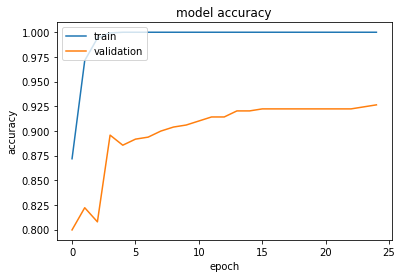

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

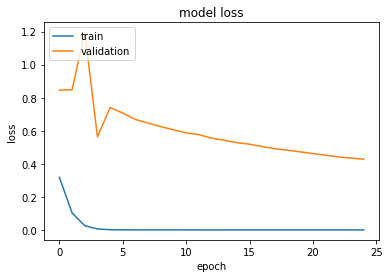

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Binary classification with random weights

In [ ]:
EPOCHS = 10
LEARNING_RATE = 0.0001

In [ ]:
# Create model with random weights
model = tf.keras.applications.MobileNetV3Small(
        input_shape=(224,224, 3), alpha=1.0, minimalistic=False, 
        include_top=True, weights=None, input_tensor=None, classes=2,
        pooling=None, dropout_rate=0.2, classifier_activation="softmax",
        include_preprocessing=True)

In [ ]:
# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.BinaryCrossentropy(), # use the binary cross entropy
    metrics=[tf.keras.metrics.BinaryAccuracy()])

In [ ]:
# Training
history = model.fit(train_ds2, epochs=EPOCHS, validation_data=test_ds2)

Epoch 1/10
47/47 [==============================] - 228s 3s/step - loss: 0.6872 - binary_accuracy: 0.5745 - val_loss: 0.6933 - val_binary_accuracy: 0.4888
Epoch 2/10
47/47 [==============================] - 87s 2s/step - loss: 0.6165 - binary_accuracy: 0.6720 - val_loss: 0.6932 - val_binary_accuracy: 0.4888
Epoch 3/10
47/47 [==============================] - 85s 2s/step - loss: 0.4752 - binary_accuracy: 0.7702 - val_loss: 0.6932 - val_binary_accuracy: 0.4888
Epoch 4/10
47/47 [==============================] - 89s 2s/step - loss: 0.3249 - binary_accuracy: 0.8570 - val_loss: 0.6931 - val_binary_accuracy: 0.5112
Epoch 5/10
47/47 [==============================] - 88s 2s/step - loss: 0.1992 - binary_accuracy: 0.9178 - val_loss: 0.6931 - val_binary_accuracy: 0.5112
Epoch 6/10
47/47 [==============================] - 85s 2s/step - loss: 0.1426 - binary_accuracy: 0.9412 - val_loss: 0.6931 - val_binary_accuracy: 0.5112
Epoch 7/10
47/47 [==============================] - 90s 2s/step - loss: 0.0

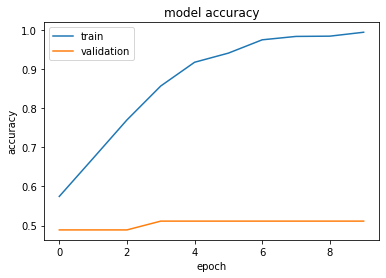

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

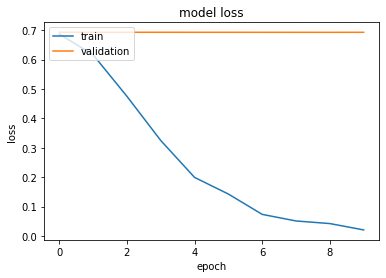

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Why doesn't the test accuracy increase? 

# Three-class classification with MobileNetV3Small



In [ ]:
# get the label for waffles
get_class_name = info.features['label'].str2int
get_class_name("waffles")

100

In [ ]:
# get the label for chocolate_cake
get_class_name = info.features['label'].str2int
get_class_name("chocolate_cake")

21

In [ ]:
# def code_data(x, y):
#   if tf.equal(y, tf.constant(76, dtype='int64')):
#     return x, tf.constant([1,0,0], dtype='int64')
#   elif tf.equal(y, tf.constant(100, dtype='int64')):
#     return x, tf.constant([0,1,0], dtype='int64')
#   else:
#     return x, tf.constant([0,0,1], dtype='int64')

In [12]:
def change_label(x, y):
  if tf.equal(y, tf.constant(76, dtype='int64')):
    return x, tf.constant(0, dtype='int64')
  elif tf.equal(y, tf.constant(100, dtype='int64')):
    return x, tf.constant(1, dtype='int64')
  else:
    return x, tf.constant(2, dtype='int64')

In [6]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomBrightness(factor = 0.2)
])

In [19]:
def get_data(ds, augment = False):
  ds1 = ds.filter(lambda x, y: y == 76 or y == 100 or y == 21)

  # resize image
  ds1 = ds1.map(lambda x, y: (tf.image.resize(x, [224, 224]), y))
  if augment:
    ds1 = ds1.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)
  ds1 = ds1.map(lambda x, y: change_label(x, y))
  return ds1

In [20]:
train_ds3 = get_data(train_ds, augment = True)
test_ds3 = get_data(test_ds)

In [21]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
train_ds3 = train_ds3.shuffle(1000).batch(BATCH_SIZE). cache(). prefetch(buffer_size=AUTOTUNE)
test_ds3 = test_ds3.shuffle(1000).batch(BATCH_SIZE). cache(). prefetch(buffer_size=AUTOTUNE)

In [22]:
# Create model
mobilenet_model = tf.keras.applications.MobileNetV3Small(
    include_top=False, weights= "imagenet",
     pooling="avg", dropout_rate=0.2, include_preprocessing=True)
predictions = tf.keras.layers.Dense(3, activation='softmax')(mobilenet_model.output)
model = Model(inputs=mobilenet_model.input, outputs=predictions)

In [23]:
EPOCHS = 25
LEARNING_RATE = 0.001

In [24]:
# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [25]:
# Training
history = model.fit(train_ds3, epochs=EPOCHS, validation_data=test_ds3)

Epoch 1/25
71/71 [==============================] - 296s 3s/step - loss: 0.3854 - sparse_categorical_accuracy: 0.8458 - val_loss: 0.8303 - val_sparse_categorical_accuracy: 0.7373
Epoch 2/25
71/71 [==============================] - 140s 2s/step - loss: 0.0861 - sparse_categorical_accuracy: 0.9689 - val_loss: 0.3932 - val_sparse_categorical_accuracy: 0.9200
Epoch 3/25
71/71 [==============================] - 141s 2s/step - loss: 0.0383 - sparse_categorical_accuracy: 0.9880 - val_loss: 0.3269 - val_sparse_categorical_accuracy: 0.9280
Epoch 4/25
71/71 [==============================] - 144s 2s/step - loss: 0.0241 - sparse_categorical_accuracy: 0.9902 - val_loss: 0.3074 - val_sparse_categorical_accuracy: 0.9387
Epoch 5/25
71/71 [==============================] - 138s 2s/step - loss: 0.0224 - sparse_categorical_accuracy: 0.9938 - val_loss: 0.4959 - val_sparse_categorical_accuracy: 0.9187
Epoch 6/25
71/71 [==============================] - 140s 2s/step - loss: 0.0517 - sparse_categorical_accu

In [26]:
print(history.history.keys())

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


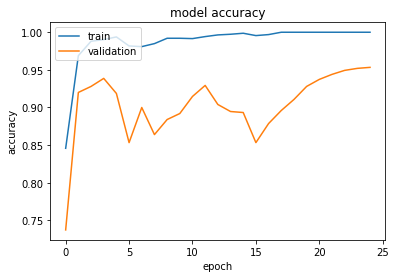

In [27]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

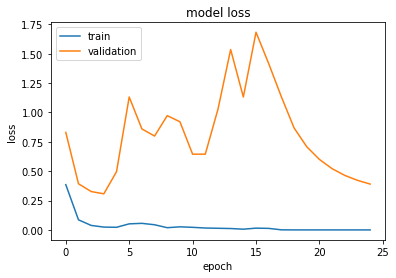

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# 101-class classification with MobileNetV3Small

In [9]:
def prepare_data(ds, augment = False):

  # resize image
  ds1 = ds.map(lambda x, y: (tf.image.resize(x, [64, 64]), y))
  if augment:
    ds1 = ds1.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=tf.data.AUTOTUNE)
  return ds1

In [10]:
train_ds101 = prepare_data(train_ds, augment = True)
test_ds101 = prepare_data(test_ds)

In [11]:
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE
train_ds101 = train_ds101.shuffle(1000).batch(BATCH_SIZE). cache(). prefetch(buffer_size=AUTOTUNE)
test_ds101 = test_ds101.shuffle(1000).batch(BATCH_SIZE). cache(). prefetch(buffer_size=AUTOTUNE)

In [12]:
# Create model
mobilenet_model = tf.keras.applications.MobileNetV3Small(
    input_shape = (64, 64, 3), include_top=False, weights= "imagenet",
     pooling="avg", dropout_rate=0.2, include_preprocessing=True)
predictions = tf.keras.layers.Dense(101, activation='softmax')(mobilenet_model.output)
model = Model(inputs=mobilenet_model.input, outputs=predictions)

In [16]:
EPOCHS = 50
LEARNING_RATE = 0.001

In [17]:
# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [18]:
# Training
history = model.fit(train_ds101, epochs=EPOCHS, validation_data=test_ds101)

Epoch 1/50
1184/1184 [==============================] - 451s 376ms/step - loss: 2.5774 - sparse_categorical_accuracy: 0.3611 - val_loss: 4.0761 - val_sparse_categorical_accuracy: 0.1788
Epoch 2/50
1184/1184 [==============================] - 446s 377ms/step - loss: 2.3174 - sparse_categorical_accuracy: 0.4130 - val_loss: 4.0145 - val_sparse_categorical_accuracy: 0.1812
Epoch 3/50
1184/1184 [==============================] - 442s 374ms/step - loss: 2.0584 - sparse_categorical_accuracy: 0.4691 - val_loss: 4.4694 - val_sparse_categorical_accuracy: 0.1645
Epoch 4/50
1184/1184 [==============================] - 442s 373ms/step - loss: 1.8218 - sparse_categorical_accuracy: 0.5183 - val_loss: 4.7812 - val_sparse_categorical_accuracy: 0.1597
Epoch 5/50
1184/1184 [==============================] - 443s 374ms/step - loss: 1.5849 - sparse_categorical_accuracy: 0.5730 - val_loss: 5.0691 - val_sparse_categorical_accuracy: 0.1541
Epoch 6/50
1184/1184 [==============================] - 440s 372ms/ste

In [21]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


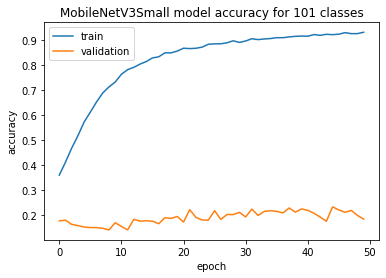

In [23]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('MobileNetV3Small model accuracy for 101 classes')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

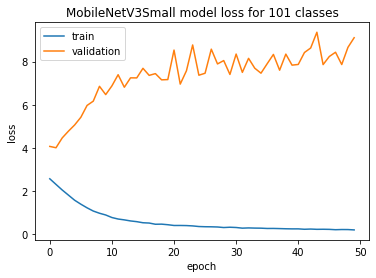

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MobileNetV3Small model loss for 101 classes')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()